In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold


In [3]:
train = pd.read_csv("../data/pre_train3.csv")
test = pd.read_csv("../data/pre_test3.csv")
y = pd.read_csv("../data/target3.csv")

In [4]:
unecessary_var =[
                #  '강남구',
                #  '송파구',
                #  '서초구',
                #  '동작구',
                #  '양천구',
                #  '성동구',
                #  '마포구',
                #  '서대문구',
                #  '용산구',
                #  '광진구',
                #  '강서구',
                #  '도봉구',
                #  '은평구',
                #  '구로구',
                #  '강동구',
                #  '영등포구',
                #  '성북구',
                #  '동대문구',
                #  '중랑구',
                #  '강북구',
                #  '노원구',
                #  '금천구',
                #  '관악구',
                #  '종로구',
                #  '중구',
                 '평균거래가 가중치2',
                 '평균거래가 가중치'
                 ]


for col in unecessary_var:
    train.drop(col, axis=1, inplace=True)
    test.drop(col, axis=1, inplace=True)

In [5]:
train.columns

Index(['동', '강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구',
       '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구', '아파트명', '도로명', '년도별_평균거래가',
       '본번', '부번', '계약년월일', '전용면적', '건축년도', '층', '좌표X', '좌표Y', '계약년도별_평균거래가',
       '인접학교거리', '인접지하철거리'],
      dtype='object')

In [6]:
# train['년도별_평균거래가'] = np.log1p(train['년도별_평균거래가'])
# test['년도별_평균거래가'] = np.log1p(test['년도별_평균거래가'])

# train['계약년도별_평균거래가'] = np.log1p(train['계약년도별_평균거래가'])
# test['계약년도별_평균거래가'] = np.log1p(test['계약년도별_평균거래가'])

In [7]:

def slicing_year_month(df):
    df["계약년월일"] = df["계약년월일"].astype(str)

    df["계약년"] = df["계약년월일"].str[:4].astype(int)
    df["계약월"] = df["계약년월일"].str[4:6].astype(int)

    df.drop(columns="계약년월일", inplace=True)
    return df


train = slicing_year_month(train)
test = slicing_year_month(test)


In [8]:
# x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=random_state_num + i)

num_split = 5

kf = KFold(n_splits = num_split, shuffle=True, random_state=42)

# for train_idx, valid_idx in kf.split(X):
#     X_train, X_valid = X[train_idx], X[valid_idx]
#     y_train, y_valid = y[train_idx], y[valid_idx]

In [12]:
### K-fold 모델 ###

random_state_num = 42

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': 1,
    'ramdom_state' : random_state_num
}

models = []

oof_predictions = np.zeros(len(train))  # Out-of-Fold 예측값 저장
test_predictions = np.zeros(len(test)) 
eval_result_append = {}


train_folds = kf.split(train, y)


for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f'Training Fold {fold_idx+1}' +  ' / ' + str(num_split))

    x_train, x_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_valid = lgb.Dataset(x_valid, y_valid)

    eval_result = {}

    gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=50000,
    # num_boost_round=20,                          # for '디버깅'...
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['training', 'validation'],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=10),
        lgb.record_evaluation(eval_result)
        ]
    )

    models.append(gbm)

    eval_result_append[f'fold_{fold_idx + 1}'] = eval_result    # 각 모델 넘버별로 저장


    oof_predictions[valid_idx] = np.expm1(gbm.predict(x_valid))

    test_predictions += np.expm1(gbm.predict(test)) / num_split


Training Fold 1 / 5
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2661
[LightGBM] [Info] Number of data points in the train set: 894997, number of used features: 41
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Info] Start training from score 10.750886
Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.473412	validation's rmse: 0.472807
[20]	training's rmse: 0.373815	validation's rmse: 0.37353
[30]	training's rmse: 0.313458	validation's rmse: 0.313466
[40]	training's rmse: 0.273667	validation's rmse: 0.273832
[50]	training's rmse: 0.247532	validation's rmse: 0.24787
[60]	training's rmse: 0.228348	validation's rmse: 0.228818

In [13]:
from sklearn.metrics import mean_squared_error

oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions))

## 모델결과 후처리

In [14]:
oof_rmse

73854.30638860802

In [15]:
rmse_train = eval_result['training']['l1']
# rmse_train = eval_result['training']['rmse']
rmse_val = eval_result['validation']['l1']
# rmse_val = eval_result['validation']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(rmse_train, label='Training RMSE')
plt.plot(rmse_val, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.title('LightGBM RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('light_gbm-4_by3_para_del-5-loss.png')

KeyError: 'l1'

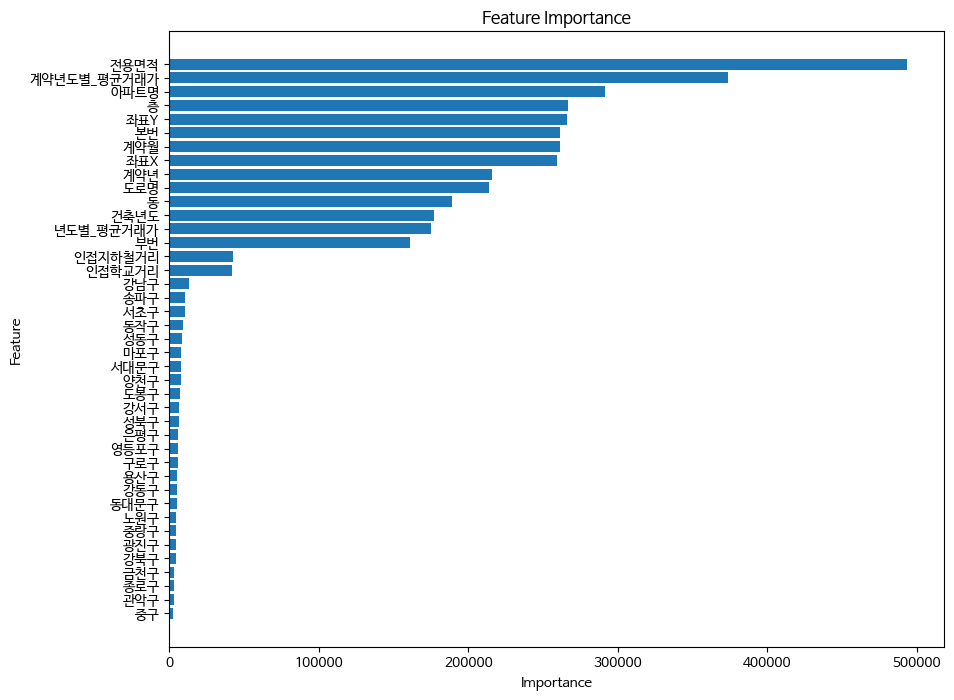

In [21]:
# gbm.feature_importance(importance_type='gain')
importances_trained = gbm.feature_importance(importance_type='split')
feature_names = gbm.feature_name()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_trained
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()
plt.savefig('light_gbm-4_by3_para_del-5_feat_importance.png')

In [16]:
models

In [17]:
import pickle

with open('../result/model_light_gbm-4_by3_parameter_del-kfold.pkl', 'wb') as f:
    pickle.dump(models, f)

In [18]:
preds_df = pd.DataFrame(test_predictions.astype(int), columns=["target"])
# display(preds_df.info())

In [19]:
preds_df.to_csv('light_gbm-4_by3_para_del-kfold.csv', index=False)

In [ ]:
preds_df.to_csv('light_gbm-4_by3_para_del-kfold.csv', index=False)